In [39]:
from mpi4py import MPI
import numpy as np
import pylab as plt

import uvtools
import hera_cal as hc
import pyuvdata
from pyuvdata import UVData

from hera_sim.visibilities import VisCPU, conversions
from hera_sim.beams import PolyBeam, PerturbedPolyBeam, ZernikeBeam

# import ultranest

try:
    import healpy
    import healvis
except:
    print("Unable to import healpy and/or healvis; diffuse mode unavailable")

from VisModel import utils
import time, copy, sys
from numba import jit
import astropy
from pyradiosky import skymodel
from scipy.linalg import cholesky, expm
from scipy.sparse.linalg import cg
import os
from astropy.time import Time
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# Begin MPI
#if use_mpi:
#    comm = MPI.COMM_WORLD
#    myid = comm.Get_rank()
#else:
#    comm = None
#    myid = 0

Unable to import healpy and/or healvis; diffuse mode unavailable


In [2]:
def zernike(coeffs, x, y):
        """
        Zernike polynomials (up to degree 66) on the unit disc.
        This code was adapted from:
        https://gitlab.nrao.edu/pjaganna/zcpb/-/blob/master/zernikeAperture.py
        Parameters
        ----------
        coeffs : array_like
            Array of real coefficients of the Zernike polynomials, from 0..66.
        x, y : array_like
            Points on the unit disc.
        Returns
        -------
        zernike : array_like
            Values of the Zernike polynomial at the input x,y points.
        """
        # Coefficients
        assert len(coeffs) <= 66, "Max. number of coeffs is 66."
        c = np.zeros(66)
        c[: len(coeffs)] += coeffs

        # Precompute powers of x and y
        x2, x3, x4, x5, x6, x7, x8, x9, x10 = tuple(x ** idx for idx in range(2, 11))
        y2, y3, y4, y5, y6, y7, y8, y9, y10 = tuple(y ** idx for idx in range(2, 11))

        # Setting the equations for the Zernike polynomials
        # r = np.sqrt(powl(x,2) + powl(y,2))
        Z = {
            1: c[0] * 1,  # m = 0    n = 0
            2: c[1] * x,  # m = -1   n = 1
            3: c[2] * y,  # m = 1    n = 1
            4: c[3] * 2 * x * y,  # m = -2   n = 2
            5: c[4] * (2 * x2 + 2 * y2 - 1),  # m = 0  n = 2
            6: c[5] * (-1 * x2 + y2),  # m = 2  n = 2
            7: c[6] * (-1 * x3 + 3 * x * y2),  # m = -3     n = 3
            8: c[7] * (-2 * x + 3 * (x3) + 3 * x * (y2)),  # m = -1   n = 3
            9: c[8] * (-2 * y + 3 * y3 + 3 * (x2) * y),  # m = 1    n = 3
            10: c[9] * (y3 - 3 * (x2) * y),  # m = 3 n =3
            11: c[10] * (-4 * (x3) * y + 4 * x * (y3)),  # m = -4    n = 4
            12: c[11] * (-6 * x * y + 8 * (x3) * y + 8 * x * (y3)),  # m = -2   n = 4
            13: c[12]
            * (
                1 - 6 * x2 - 6 * y2 + 6 * x4 + 12 * (x2) * (y2) + 6 * y4
            ),  # m = 0  n = 4
            14: c[13] * (3 * x2 - 3 * y2 - 4 * x4 + 4 * y4),  # m = 2    n = 4
            15: c[14] * (x4 - 6 * (x2) * (y2) + y4),  # m = 4   n = 4
            16: c[15] * (x5 - 10 * (x3) * y2 + 5 * x * (y4)),  # m = -5   n = 5
            17: c[16]
            * (
                4 * x3 - 12 * x * (y2) - 5 * x5 + 10 * (x3) * (y2) + 15 * x * y4
            ),  # m =-3     n = 5
            18: c[17]
            * (
                3 * x
                - 12 * x3
                - 12 * x * (y2)
                + 10 * x5
                + 20 * (x3) * (y2)
                + 10 * x * (y4)
            ),  # m= -1  n = 5
            19: c[18]
            * (
                3 * y
                - 12 * y3
                - 12 * y * (x2)
                + 10 * y5
                + 20 * (y3) * (x2)
                + 10 * y * (x4)
            ),  # m = 1  n = 5
            20: c[19]
            * (
                -4 * y3 + 12 * y * (x2) + 5 * y5 - 10 * (y3) * (x2) - 15 * y * x4
            ),  # m = 3   n = 5
            21: c[20] * (y5 - 10 * (y3) * x2 + 5 * y * (x4)),  # m = 5 n = 5
            22: c[21]
            * (6 * (x5) * y - 20 * (x3) * (y3) + 6 * x * (y5)),  # m = -6 n = 6
            23: c[22]
            * (
                20 * (x3) * y - 20 * x * (y3) - 24 * (x5) * y + 24 * x * (y5)
            ),  # m = -4   n = 6
            24: c[23]
            * (
                12 * x * y
                + 40 * (x3) * y
                - 40 * x * (y3)
                + 30 * (x5) * y
                + 60 * (x3) * (y3)
                - 30 * x * (y5)
            ),  # m = -2   n = 6
            25: c[24]
            * (
                -1
                + 12 * (x2)
                + 12 * (y2)
                - 30 * (x4)
                - 60 * (x2) * (y2)
                - 30 * (y4)
                + 20 * (x6)
                + 60 * (x4) * y2
                + 60 * (x2) * (y4)
                + 20 * (y6)
            ),  # m = 0   n = 6
            26: c[25]
            * (
                -6 * (x2)
                + 6 * (y2)
                + 20 * (x4)
                - 20 * (y4)
                - 15 * (x6)
                - 15 * (x4) * (y2)
                + 15 * (x2) * (y4)
                + 15 * (y6)
            ),  # m = 2   n = 6
            27: c[26]
            * (
                -5 * (x4)
                + 30 * (x2) * (y2)
                - 5 * (y4)
                + 6 * (x6)
                - 30 * (x4) * y2
                - 30 * (x2) * (y4)
                + 6 * (y6)
            ),  # m = 4    n = 6
            28: c[27]
            * (-1 * (x6) + 15 * (x4) * (y2) - 15 * (x2) * (y4) + y6),  # m = 6   n = 6
            29: c[28]
            * (
                -1 * (x7) + 21 * (x5) * (y2) - 35 * (x3) * (y4) + 7 * x * (y6)
            ),  # m = -7    n = 7
            30: c[29]
            * (
                -6 * (x5)
                + 60 * (x3) * (y2)
                - 30 * x * (y4)
                + 7 * x7
                - 63 * (x5) * (y2)
                - 35 * (x3) * (y4)
                + 35 * x * (y6)
            ),  # m = -5    n = 7
            31: c[30]
            * (
                -10 * (x3)
                + 30 * x * (y2)
                + 30 * x5
                - 60 * (x3) * (y2)
                - 90 * x * (y4)
                - 21 * x7
                + 21 * (x5) * (y2)
                + 105 * (x3) * (y4)
                + 63 * x * (y6)
            ),  # m =-3       n = 7
            32: c[31]
            * (
                -4 * x
                + 30 * x3
                + 30 * x * (y2)
                - 60 * (x5)
                - 120 * (x3) * (y2)
                - 60 * x * (y4)
                + 35 * x7
                + 105 * (x5) * (y2)
                + 105 * (x3) * (y4)
                + 35 * x * (y6)
            ),  # m = -1  n = 7
            33: c[32]
            * (
                -4 * y
                + 30 * y3
                + 30 * y * (x2)
                - 60 * (y5)
                - 120 * (y3) * (x2)
                - 60 * y * (x4)
                + 35 * y7
                + 105 * (y5) * (x2)
                + 105 * (y3) * (x4)
                + 35 * y * (x6)
            ),  # m = 1   n = 7
            34: c[33]
            * (
                10 * (y3)
                - 30 * y * (x2)
                - 30 * y5
                + 60 * (y3) * (x2)
                + 90 * y * (x4)
                + 21 * y7
                - 21 * (y5) * (x2)
                - 105 * (y3) * (x4)
                - 63 * y * (x6)
            ),  # m =3     n = 7
            35: c[34]
            * (
                -6 * (y5)
                + 60 * (y3) * (x2)
                - 30 * y * (x4)
                + 7 * y7
                - 63 * (y5) * (x2)
                - 35 * (y3) * (x4)
                + 35 * y * (x6)
            ),  # m = 5  n = 7
            36: c[35]
            * (y7 - 21 * (y5) * (x2) + 35 * (y3) * (x4) - 7 * y * (x6)),  # m = 7  n = 7
            37: c[36]
            * (
                -8 * (x7) * y + 56 * (x5) * (y3) - 56 * (x3) * (y5) + 8 * x * (y7)
            ),  # m = -8  n = 8
            38: c[37]
            * (
                -42 * (x5) * y
                + 140 * (x3) * (y3)
                - 42 * x * (y5)
                + 48 * (x7) * y
                - 112 * (x5) * (y3)
                - 112 * (x3) * (y5)
                + 48 * x * (y7)
            ),  # m = -6  n = 8
            39: c[38]
            * (
                -60 * (x3) * y
                + 60 * x * (y3)
                + 168 * (x5) * y
                - 168 * x * (y5)
                - 112 * (x7) * y
                - 112 * (x5) * (y3)
                + 112 * (x3) * (y5)
                + 112 * x * (y7)
            ),  # m = -4   n = 8
            40: c[39]
            * (
                -20 * x * y
                + 120 * (x3) * y
                + 120 * x * (y3)
                - 210 * (x5) * y
                - 420 * (x3) * (y3)
                - 210 * x * (y5)
                - 112 * (x7) * y
                + 336 * (x5) * (y3)
                + 336 * (x3) * (y5)
                + 112 * x * (y7)
            ),  # m = -2   n = 8
            41: c[40]
            * (
                1
                - 20 * x2
                - 20 * y2
                + 90 * x4
                + 180 * (x2) * (y2)
                + 90 * y4
                - 140 * x6
                - 420 * (x4) * (y2)
                - 420 * (x2) * (y4)
                - 140 * (y6)
                + 70 * x8
                + 280 * (x6) * (y2)
                + 420 * (x4) * (y4)
                + 280 * (x2) * (y6)
                + 70 * y8
            ),  # m = 0    n = 8
            42: c[41]
            * (
                10 * x2
                - 10 * y2
                - 60 * x4
                + 105 * (x4) * (y2)
                - 105 * (x2) * (y4)
                + 60 * y4
                + 105 * x6
                - 105 * y6
                - 56 * x8
                - 112 * (x6) * (y2)
                + 112 * (x2) * (y6)
                + 56 * y8
            ),  # m = 2  n = 8
            43: c[42]
            * (
                15 * x4
                - 90 * (x2) * (y2)
                + 15 * y4
                - 42 * x6
                + 210 * (x4) * (y2)
                + 210 * (x2) * (y4)
                - 42 * y6
                + 28 * x8
                - 112 * (x6) * (y2)
                - 280 * (x4) * (y4)
                - 112 * (x2) * (y6)
                + 28 * y8
            ),  # m = 4     n = 8
            44: c[43]
            * (
                7 * x6
                - 105 * (x4) * (y2)
                + 105 * (x2) * (y4)
                - 7 * y6
                - 8 * x8
                + 112 * (x6) * (y2)
                - 112 * (x2) * (y6)
                + 8 * y8
            ),  # m = 6    n = 8
            45: c[44]
            * (
                x8 - 28 * (x6) * (y2) + 70 * (x4) * (y4) - 28 * (x2) * (y6) + y8
            ),  # m = 8     n = 9
            46: c[45]
            * (
                x9
                - 36 * (x7) * (y2)
                + 126 * (x5) * (y4)
                - 84 * (x3) * (y6)
                + 9 * x * (y8)
            ),  # m = -9     n = 9
            47: c[46]
            * (
                8 * x7
                - 168 * (x5) * (y2)
                + 280 * (x3) * (y4)
                - 56 * x * (y6)
                - 9 * x9
                + 180 * (x7) * (y2)
                - 126 * (x5) * (y4)
                - 252 * (x3) * (y6)
                + 63 * x * (y8)
            ),  # m = -7    n = 9
            48: c[47]
            * (
                21 * x5
                - 210 * (x3) * (y2)
                + 105 * x * (y4)
                - 56 * x7
                + 504 * (x5) * (y2)
                + 280 * (x3) * (y4)
                - 280 * x * (y6)
                + 36 * x9
                - 288 * (x7) * (y2)
                - 504 * (x5) * (y4)
                + 180 * x * (y8)
            ),  # m = -5    n = 9
            49: c[48]
            * (
                20 * x3
                - 60 * x * (y2)
                - 105 * x5
                + 210 * (x3) * (y2)
                + 315 * x * (y4)
                + 168 * x7
                - 168 * (x5) * (y2)
                - 840 * (x3) * (y4)
                - 504 * x * (y6)
                - 84 * x9
                + 504 * (x5) * (y4)
                + 672 * (x3) * (y6)
                + 252 * x * (y8)
            ),  # m = -3  n = 9
            50: c[49]
            * (
                5 * x
                - 60 * x3
                - 60 * x * (y2)
                + 210 * x5
                + 420 * (x3) * (y2)
                + 210 * x * (y4)
                - 280 * x7
                - 840 * (x5) * (y2)
                - 840 * (x3) * (y4)
                - 280 * x * (y6)
                + 126 * x9
                + 504 * (x7) * (y2)
                + 756 * (x5) * (y4)
                + 504 * (x3) * (y6)
                + 126 * x * (y8)
            ),  # m = -1   n = 9
            51: c[50]
            * (
                5 * y
                - 60 * y3
                - 60 * y * (x2)
                + 210 * y5
                + 420 * (y3) * (x2)
                + 210 * y * (x4)
                - 280 * y7
                - 840 * (y5) * (x2)
                - 840 * (y3) * (x4)
                - 280 * y * (x6)
                + 126 * y9
                + 504 * (y7) * (x2)
                + 756 * (y5) * (x4)
                + 504 * (y3) * (x6)
                + 126 * y * (x8)
            ),  # m = -1   n = 9
            52: c[51]
            * (
                -20 * y3
                + 60 * y * (x2)
                + 105 * y5
                - 210 * (y3) * (x2)
                - 315 * y * (x4)
                - 168 * y7
                + 168 * (y5) * (x2)
                + 840 * (y3) * (x4)
                + 504 * y * (x6)
                + 84 * y9
                - 504 * (y5) * (x4)
                - 672 * (y3) * (x6)
                - 252 * y * (x8)
            ),  # m = 3  n = 9
            53: c[52]
            * (
                21 * y5
                - 210 * (y3) * (x2)
                + 105 * y * (x4)
                - 56 * y7
                + 504 * (y5) * (x2)
                + 280 * (y3) * (x4)
                - 280 * y * (x6)
                + 36 * y9
                - 288 * (y7) * (x2)
                - 504 * (y5) * (x4)
                + 180 * y * (x8)
            ),  # m = 5     n = 9
            54: c[53]
            * (
                -8 * y7
                + 168 * (y5) * (x2)
                - 280 * (y3) * (x4)
                + 56 * y * (x6)
                + 9 * y9
                - 180 * (y7) * (x2)
                + 126 * (y5) * (x4)
                - 252 * (y3) * (x6)
                - 63 * y * (x8)
            ),  # m = 7     n = 9
            55: c[54]
            * (
                y9
                - 36 * (y7) * (x2)
                + 126 * (y5) * (x4)
                - 84 * (y3) * (x6)
                + 9 * y * (x8)
            ),  # m = 9       n = 9
            56: c[55]
            * (
                10 * (x9) * y
                - 120 * (x7) * (y3)
                + 252 * (x5) * (y5)
                - 120 * (x3) * (y7)
                + 10 * x * (y9)
            ),  # m = -10   n = 10
            57: c[56]
            * (
                72 * (x7) * y
                - 504 * (x5) * (y3)
                + 504 * (x3) * (y5)
                - 72 * x * (y7)
                - 80 * (x9) * y
                + 480 * (x7) * (y3)
                - 480 * (x3) * (y7)
                + 80 * x * (y9)
            ),  # m = -8    n = 10
            58: c[57]
            * (
                270 * (x9) * y
                - 360 * (x7) * (y3)
                - 1260 * (x5) * (y5)
                - 360 * (x3) * (y7)
                + 270 * x * (y9)
                - 432 * (x7) * y
                + 1008 * (x5) * (y3)
                + 1008 * (x3) * (y5)
                - 432 * x * (y7)
                + 168 * (x5) * y
                - 560 * (x3) * (y3)
                + 168 * x * (y5)
            ),  # m = -6   n = 10
            59: c[58]
            * (
                140 * (x3) * y
                - 140 * x * (y3)
                - 672 * (x5) * y
                + 672 * x * (y5)
                + 1008 * (x7) * y
                + 1008 * (x5) * (y3)
                - 1008 * (x3) * (y5)
                - 1008 * x * (y7)
                - 480 * (x9) * y
                - 960 * (x7) * (y3)
                + 960 * (x3) * (y7)
                + 480 * x * (y9)
            ),  # m = -4   n = 10
            60: c[59]
            * (
                30 * x * y
                - 280 * (x3) * y
                - 280 * x * (y3)
                + 840 * (x5) * y
                + 1680 * (x3) * (y3)
                + 840 * x * (y5)
                - 1008 * (x7) * y
                - 3024 * (x5) * (y3)
                - 3024 * (x3) * (y5)
                - 1008 * x * (y7)
                + 420 * (x9) * y
                + 1680 * (x7) * (y3)
                + 2520 * (x5) * (y5)
                + 1680 * (x3) * (y7)
                + 420 * x * (y9)
            ),  # m = -2   n = 10
            61: c[60]
            * (
                -1
                + 30 * x2
                + 30 * y2
                - 210 * x4
                - 420 * (x2) * (y2)
                - 210 * y4
                + 560 * x6
                + 1680 * (x4) * (y2)
                + 1680 * (x2) * (y4)
                + 560 * y6
                - 630 * x8
                - 2520 * (x6) * (y2)
                - 3780 * (x4) * (y4)
                - 2520 * (x2) * (y6)
                - 630 * y8
                + 252 * x10
                + 1260 * (x8) * (y2)
                + 2520 * (x6) * (y4)
                + 2520 * (x4) * (y6)
                + 1260 * (x2) * (y8)
                + 252 * y10
            ),  # m = 0    n = 10
            62: c[61]
            * (
                -15 * x2
                + 15 * y2
                + 140 * x4
                - 140 * y4
                - 420 * x6
                - 420 * (x4) * (y2)
                + 420 * (x2) * (y4)
                + 420 * y6
                + 504 * x8
                + 1008 * (x6) * (y2)
                - 1008 * (x2) * (y6)
                - 504 * y8
                - 210 * x10
                - 630 * (x8) * (y2)
                - 420 * (x6) * (y4)
                + 420 * (x4) * (y6)
                + 630 * (x2) * (y8)
                + 210 * y10
            ),  # m = 2  n = 10
            63: c[62]
            * (
                -35 * x4
                + 210 * (x2) * (y2)
                - 35 * y4
                + 168 * x6
                - 840 * (x4) * (y2)
                - 840 * (x2) * (y4)
                + 168 * y6
                - 252 * x8
                + 1008 * (x6) * (y2)
                + 2520 * (x4) * (y4)
                + 1008 * (x2) * (y6)
                - 252 * (y8)
                + 120 * x10
                - 360 * (x8) * (y2)
                - 1680 * (x6) * (y4)
                - 1680 * (x4) * (y6)
                - 360 * (x2) * (y8)
                + 120 * y10
            ),  # m = 4     n = 10
            64: c[63]
            * (
                -28 * x6
                + 420 * (x4) * (y2)
                - 420 * (x2) * (y4)
                + 28 * y6
                + 72 * x8
                - 1008 * (x6) * (y2)
                + 1008 * (x2) * (y6)
                - 72 * y8
                - 45 * x10
                + 585 * (x8) * (y2)
                + 630 * (x6) * (y4)
                - 630 * (x4) * (y6)
                - 585 * (x2) * (y8)
                + 45 * y10
            ),  # m = 6    n = 10
            65: c[64]
            * (
                -9 * x8
                + 252 * (x6) * (y2)
                - 630 * (x4) * (y4)
                + 252 * (x2) * (y6)
                - 9 * y8
                + 10 * x10
                - 270 * (x8) * (y2)
                + 420 * (x6) * (y4)
                + 420 * (x4) * (y6)
                - 270 * (x2) * (y8)
                + 10 * y10
            ),  # m = 8    n = 10
            66: c[65]
            * (
                -1 * x10
                + 45 * (x8) * (y2)
                - 210 * (x6) * (y4)
                + 210 * (x4) * (y6)
                - 45 * (x2) * (y8)
                + y10
            ),  # m = 10   n = 10
        }
        return Z
    


In [3]:
class beam_sampler:
    
    def __init__(self, skymodel, uvd, initial_zernike_coeffs, noise_cov, prior_mean_block=None,
                 prior_cov_block=None):
        if uvd.Nfreqs > 1:
            msg = "Multifrequency sampling not implemented yet. Please trim UVData object to one frequency."
            raise ValueError(msg)
        if uvd.Ntimes > 1:
            msg = "Multitime sampling not implemented yet. Please trim UVData object to one time."
            raise ValueError(msg)
        
        self.skymodel = skymodel
        self.uvd = uvd
        self.noise_cov = noise_cov
        self.noise_cov_inv = np.linalg.inv(self.noise_cov)
        
        self.skymodel.update_locations(np.unique(self.uvd.time_array), self.uvd.telescope_location)
        
        #self.rhos = np.sqrt(np.sum(self.skymodel.pos_lmn[:2, :]**2, axis=0))
        #self.phis = np.arctan2(self.skymodel.pos_lmn[1, :] / self.skymodel.pos_lmn[0, :])
        self.fourier = self.get_fourier()
        
        
        self.initial_zernike_coeffs = initial_zernike_coeffs
        self.n_coeff = len(self.initial_zernike_coeffs)
        self.zernike_matrix = self.get_zernike_matrix()
        
        # Start with them redundant
        self.initial_beam = self.zernike_matrix @ self.initial_zernike_coeffs
        self.beam_block = np.repeat(self.initial_beam[np.newaxis, :], self.uvd.Nbls, axis=0)
        
        self.fourier_sky = self.fourier * self.skymodel.stokes[0, 0, :]
        
        self.ant_pointers = self.get_ant_pointers()
        self.ant_pointers = [np.where(self.uvd.ant_1_array == ant_num for ant_num in self.uvd.antenna_numbers)]
        
        self.prior_mean_block = prior_mean_block
        self.prior_cov_block = prior_cov_block
        
        if self.prior_mean_block is None:
            self.prior_mean_block = 0
        if self.prior_cov_block is None:
            self.prior_cov_block = 0
            self.prior_cov_block_inv = 0
        else:
            self.prior_cov_block_inv = np.copy(self.prior_cov_block)
            for ant_ind in range(self.uvd.Nants_data):
                ind_start, ind_end = self.get_start_stop()
                prior_cov_sb = self.prior_cov_block[ind_start:ind_end]
                self.prior_cov_block_inv[ind_start:ind_end] = np.linalg.inv(prior_cov_sb)
            self.prior_mean_cache = self.prior_cov_block_inv @ self.prior_mean_block.T
                
        
        
    def get_fourier(self):
        
        # Get the phases modulo 2pi by dotting uv(w) array into lm array
        u_dot_lm = self.uvd.uvw_array[:, :2] @ self.skymodel.pos_lmn[:2, :]
        
        fouerier_arg = -2 * np.pi * 1j * u_dot_lm
        
        fourier = np.exp(fourier_arg)

        
        return(fourier)
    
    def get_zernike_matrix(self):
        # Just give each polynomial, no coeff
        coeffs_ones = np.ones(66)
        zernike_dict = zernike(coeffs_ones, *self.skymodel.pos_lmn[:2, :])
        # Only get the first n_coeff rows
        zerike_matr = np.array(list(zernike_dict.values())[:self.n_coeffs])
        
        return(zernike_matr)
    
    def get_ant_pointers(self):
        ant_pointers = []
        for ant_num in self.uvd.antenna_numbers:
            ant_1_cond = (self.ant_1_array == ant_num)
            ant_2_cond = (self.ant_2_array == ant_num)
            
            ant_pointers.append(np.where((ant_1_cond or ant_2_cond)))
        
        return(ant_pointers)
    
    def get_start_stop(self, ant_ind):
        ind_start = ant_ind * self.uvd.Nants_data
        ind_end = (ant_ind + 1) * self.uvd.Nants_data
        
        return(ind_start, ind_end)
    
    def get_gibbs_samples(self, N_iter=1000):
        if not isinstance(N_iter, int):
            N_iter = int(N_iter)
        samples = []
        for sample_ind in range(N_iter):
            new_sample = []
            for ant_ind in range(self.uvd.Nants_data):
                ### Need to sanity check this section ###
                block_inds = np.delete(np.arange(self.uvd.Nants_data), ant_ind)
                beam_sb = (self.zernike_matrix @ self.beam_block[block_inds, :].T).T
                fourier_sb = self.sky_fourier[ant_pointers[ant_ind], :]
                vis_sb = self.uvd.data_array[ant_pointers[ant_ind], 0, 0, 0]
                
                # Have to conjugate to make sure we are sampling B and not B*
                if ant_ind:
                    fourier_sb[:ant_ind] = np.conj(fourier_sb[:ant_ind])
                    vis_sb[:ant_ind] = np.conj(vis_sb[:ant_ind])
                
                T = (fourier_sb * np.conj(beam_sb)) @ self.zernike_matrix
                ### Need to sanity check this section ###
                
                Tdag_Ninv = np.conj(T.T)@self.noise_cov_inv
                Tdag_Ninv_T = Tdag_N@T
                
                ind_start, ind_end = self.get_start_stop(ant_ind)
                prior_cov_inv_sb = self.prior_cov_inv[ind_start:ind_end]
                prior_mean_cache_sb = self.prior_mean_cache[ant_ind]
                
                
                
                A = Tdag_Ninv_T + prior_cov_inv_sb
                
                cho = cholesky(A)
                b = prior_mean_cache_sb + Tdag_Ninv@vis_sb + A@(np.random.normal(size=n_coeff) + 1.0j*np.random.normal(size=n_coeff))
        
                sample = np.linalg.solve(A, b)
                new_sample.append(sample)
            samples.append(new_sample)
            
        return(samples)
                
            
            
        
        
            
        

In [4]:
def default_cfg():
    """
    Set parameter defaults.
    """
    # Simulation specification
    cfg_spec = dict( nfreq=16,
                     start_freq=1.e8,
                     bandwidth=0.2e8,
                     start_time=2458902.33333,
                     integration_time=40.,
                     ntimes=3,
                     cat_name="gleamegc.dat",
                     apply_gains=True,
                     apply_noise=True,
                     ant_pert=False,
                     seed=None,
                     ant_pert_sigma=0.0,
                     use_legacy_array=False,
                     hex_spec=(3,4), 
                     hex_ants_per_row=None, 
                     hex_ant_sep=14.6,
                     use_ptsrc=True )
                        
    # Diffuse model specification
    cfg_diffuse = dict( use_diffuse=False,
                        nside=64,
                        obs_latitude=-30.7215277777,
                        obs_longitude = 21.4283055554,
                        obs_height = 1073,
                        beam_pol='XX',
                        diffuse_model='GSM',
                        eor_random_seed=42,
                        nprocs=1 )
    
    # Beam model parameters
    cfg_beam = dict( ref_freq=1.e8,
                     spindex=-0.6975,
                     seed=None,
                     perturb_scale=0.0,
                     mainlobe_scale=1.0,
                     xstretch=1.0,
                     ystretch=1.0,
                     xystretch_same=True,
                     xystretch_dist=None,
                     rotation_dist='',
                     rotation=0.0,
                     mainlobe_width=0.3, 
                     nmodes=8,
                     beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )
    
    # Fluctuating gain model parameters
    cfg_gain = dict(nmodes=8, seed=None)
    
    # Noise parameters
    cfg_noise = dict(nsamp=1., seed=None, noise_file=None)
    
    # Combine into single dict
    cfg = { 'sim_beam':     cfg_beam,
            'sim_spec':     cfg_spec,
            'sim_diffuse':  cfg_diffuse,
            'sim_noise':    cfg_noise,
            'sim_gain':     cfg_gain,
           }
    return cfg

In [5]:
class VisModel(object):
    
    def __init__(self, uvd_init, 
                 ptsrc_ra_dec, ptsrc_flux,
                 beam_model=PerturbedPolyBeam, 
                 default_beam_params={},
                 free_params_antpos=[], free_params_beam=[], 
                 free_params_ptsrc=[],
                 free_beams=[], free_ants=[], free_ptsrcs=[],
                 verbose=False, comm=None):
        """
        Construct a model for a set of visibility data from a series 
        of data model components. This object handles caching of 
        results to avoid expensive recomputations where possible.
        
        Parameters
        ----------
        uvd_init : UVData object
            UVData object with the correct data shape (number of 
            frequencies, times, polarisations, antennas).
        
        ptsrc_ra_dec, ptsrc_flux : array_like
            Point source position and flux arrays.
        
        beam_model : UVBeam, optional
            Beam model class to be used for the primary beams.
            Default: PerturbedPolyBeam
        
        default_beam_params : dict
            Default values of all beam model parameters.
        
        free_params_antpos, free_params_beam, free_params_ptsrc : lists of str
            Ordered lists of names of parameters to be varied. 
            The ordering maps to the parameter vector.
        
        free_beams, free_ants, free_ptsrcs : list of int
            Ordered list of which beams/antennas/point sources 
            are to have their parameters varied. The ordering 
            maps to the parameter vector.
        
        verbose : bool, optional
            Whether to print debug messages. Default: True.
        
        comm : MPI communicator, optional
            MPI communicator to be passed to simulator. Default: None.
        """
        # Set basic parameters
        assert isinstance(uvd_init, UVData), "uvd_init must be a valid UVData object"
        self.verbose = verbose
        
        # Store basic data object
        self.uvd = copy.deepcopy(uvd_init)
        
        # General settings
        self._freqs = np.unique(self.uvd.freq_array)
        self._ant_index = self.uvd.antenna_numbers
        
        # Initial antenna positions (for antennas with free positions)
        self.antpos_initial = {}
        for ant in free_ants:
            pos = self.uvd.antenna_positions[np.where(self.uvd.antenna_numbers == ant)]
            self.antpos_initial[ant] = pos.flatten()
        
        # Set beam type
        self.BeamClass = beam_model
        self.beams = [[] for i in range(self.uvd.Nants_data)]
        self.default_beam_params = default_beam_params
        
        # Point source catalogue
        self.ptsrc_ra_dec = ptsrc_ra_dec.copy()
        self.ptsrc_flux = ptsrc_flux.copy()
        self.ptsrc_delta_radec = np.zeros(self.ptsrc_ra_dec.shape)
        self.ptsrc_flux_factor = np.ones(self.ptsrc_ra_dec.shape[0])
        
        # Mappings between param vector and param names
        self.free_params_antpos = free_params_antpos
        self.free_params_beam = free_params_beam
        self.free_params_ptsrc = free_params_ptsrc
        self.free_beams = free_beams
        self.free_ants = free_ants
        self.free_ptsrcs = free_ptsrcs
        
        # MPI handling
        self.comm = comm
        
        # Construct beam model with new parameter values
        for i in range(self.uvd.Nants_data):
            self.beams[i] = self.BeamClass(**self.default_beam_params)
        
        # Model visibility:
        #   Antenna positions
        #   Primary beam models
        #   Sky model: point sources
        #   Sky model: Gaussian sources
        #   Sky model: diffuse
    
    
    def set_antpos(self, ant, params):
        """
        Set position parameters of named antenna.
        
        Parameters
        ----------
        ant : int
            Antenna ID.
        
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_antpos`.
        """
        # Extract antenna position parameters
        vec = np.zeros(3)
        j = 0
        for i, p in enumerate(['antpos_dx', 'antpos_dy', 'antpos_dz']):
            if p in self.free_params_antpos:
                vec[i] = params[j]
                j += 1
        
        # Update antenna positions
        self.uvd.antenna_positions[ant] = self.antpos_initial[ant] + vec
    
    
    def set_beam(self, ant, params):
        """
        Set the parameters of a beam.
        
        Parameters
        ----------
        ant : int
            Antenna ID.
            
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_beams`.
        """
        assert len(params) == len(self.free_params_beam)
        
        # Copy default parameter values
        param_dict = copy.copy(self.default_beam_params)
        
        # Update parameter values that have changed
        for i, pname in enumerate(self.free_params_beam):
            param_dict[pname] = params[i]
        
        # Construct beam model with new parameter values
        idx = np.where(self._ant_index == ant)[0][0]
        self.beams[idx] = self.BeamClass(**param_dict)
        # First arg is: perturb_coeffs=[0.,]
    
    
    def set_ptsrc_params(self, i, params):
        """
        Set the parameters of a point source.
        
        Parameters
        ----------
        i : int
            Point source index in the catalogue.
            
        params : array_like
            Vector of parameters. Names and ordering are defined 
            in `self.free_params_ptsrcs`.
        """
        # Set point source parameters if specified
        if 'delta_ra' in self.free_params_ptsrc:
            self.ptsrc_delta_radec[i][0] = params[self.free_params_ptsrc.index('delta_ra')]
        if 'delta_dec' in self.free_params_ptsrc:
            self.ptsrc_delta_radec[i][1] = params[self.free_params_ptsrc.index('delta_dec')]
        if 'flux_factor' in self.free_params_ptsrc:
            self.ptsrc_flux_factor[i] = params[self.free_params_ptsrc.index('flux_factor')]
    
    
    def param_names(self):
        """
        Return list of parameter names in order.
        """
        pnames = []
        
        # Antenna position parameters
        for ant in self.free_ants:
            for p in self.free_params_antpos:
                pnames.append("%s_%03d" % (p, ant))
        
        # Beam parameters
        for ant in self.free_beams:
            for p in self.free_params_beam:
                pnames.append("%s_%03d" % (p, ant))
        
        # Point source parameters
        for i in self.free_ptsrcs:
            for p in self.free_params_ptsrc:
                pnames.append("%s_%06d" % (p, i))
        
        return pnames
    
    
    def simulate(self):
        """
        Simulate visibilities for the current state of the model.
        """
        # Need to zero the array, which is usually returned by 
        # reference rather than copied
        self.uvd.data_array *= 0.
        
        # Construct new simulator class with updated settings
        simulator = VisCPU(
            uvdata=self.uvd,                          # fixed
            beams=self.beams,                         # varies
            beam_ids=self._ant_index,                 # fixed
            sky_freqs=self._freqs,                    # fixed
            point_source_pos=self.ptsrc_ra_dec + self.ptsrc_delta_radec, # varies
            point_source_flux=self.ptsrc_flux * self.ptsrc_flux_factor,  # varies
            precision=2,                              # fixed
            use_pixel_beams=False, # Do not use pixel beams
            bm_pix=10,
            mpi_comm=self.comm
        )
        
        # Run simulation
        if self.verbose:
            print("  Beginning simulation")
        tstart = time.time()
        simulator.simulate()
        if self.verbose:
            print("  Simulation took %2.1f sec" % (time.time() - tstart))
    
        #if myid != 0:
        #    # Wait for root worker to finish IO before ending all other worker procs
        #    comm.Barrier()
        #    sys.exit(0)
        
        return simulator.uvdata
    
    
    def model(self, params):
        """
        Calculate model visibilities for a given parameter vector.
        
        Parameters
        ----------
        params : array_like
            Vector of parameter values. The number of parameters 
            and position of each parameter in the vector must 
            follow the specification 
        """
        params = np.array(params)
        
        # Count free parameters and antennas/beams
        Nfree_ants = len(self.free_ants)
        Nfree_beams = len(self.free_beams)
        Nfree_ptsrcs = len(self.free_ptsrcs)
        Nparams_ants = len(self.free_params_antpos)
        Nparams_beams = len(self.free_params_beam)
        Nparams_ptsrcs = len(self.free_params_ptsrc)
        
        # Extract parameters in blocks and reshape
        iants = Nfree_ants * Nparams_ants
        ibeams = Nfree_beams * Nparams_beams
        iptsrcs = Nfree_ptsrcs * Nparams_ptsrcs
        antpos_params = params[0:iants].reshape((Nfree_ants, Nparams_ants))
        beam_params = params[iants:iants+ibeams].reshape((Nfree_beams, Nparams_beams))
        ptsrc_params = params[iants+ibeams:iants+ibeams+iptsrcs].reshape((Nfree_ptsrcs, Nparams_ptsrcs))
        
        # (1) Antenna positions
        for i, ant in enumerate(self.free_ants):
            self.set_antpos(ant, antpos_params[i])
        
        # (2) Beam parameters
        for i, ant in enumerate(self.free_beams):
            self.set_beam(ant, beam_params[i])
        
        # (3) Point source parameters
        for i in self.free_ptsrcs:
            self.set_ptsrc_params(i, ptsrc_params[i])
        
        # Run simulation
        _uvd = self.simulate()
        self.uvd = _uvd
        return _uvd

In [24]:
uvd_inpath = "/Users/mike_e_dubs/HERA/Data/H1C_IDR2/zen.2458098.38650.HH.uvh5"
assert os.path.exists(uvd_inpath), "Path to visibility file does not exist. Check uvd_inpath variable."


uvd = UVData()
uvd.read(uvd_inpath, read_data=False)

print(f"Number of times in data file: {uvd.Ntimes}")
print(f"Number of freqs in data file: {uvd.Nfreqs}")
print(f"Number of ants in data file: {uvd.Nants_data}")
print(f"Number of ants in data file: {uvd.Npols}")

# Make some arbitrary selections for the data file:
# 1 time, 1 freq, 1 pol, 10 ants
chosen_time = np.unique(uvd.time_array)[10]
chosen_freq_chan = 500
ant_nums = np.unique(uvd.antenna_numbers[:10])
pol = uvd.polarization_array[0]
 
uvd.read(uvd_inpath, times=chosen_time, freq_chans=chosen_freq_chan,
         antenna_nums=ant_nums, polarizations=pol)

# Check that it went as intended (mostly looking at antennas here)
print(f"Number of times in data file after select: {uvd.Ntimes}")
print(f"Number of freqs in data file after select: {uvd.Nfreqs}")
print(f"Number of ants in data file after select: {uvd.Nants_data}")
print(f"Number of ants in data file after select: {uvd.Npols}")

Number of times in data file: 60
Number of freqs in data file: 1024
Number of ants in data file: 52
Number of ants in data file: 4
Number of times in data file after select: 1
Number of freqs in data file after select: 1
Number of ants in data file after select: 10
Number of ants in data file after select: 1


# Phase to zenith so that ra/dec can be used to construct a source list

In [31]:
uvd.phase_to_time(Time(uvd.time_array[0], format='jd'))

# Want to generate uniform points on a sphere

In [53]:
Nsource = 10

# 12 degrees in radians (twice a beam width)
offset = np.pi / 15

dec_low = uvd.phase_center_dec - offset
dec_high = uvd.phase_center_dec + offset

ra_low = uvd.phase_center_ra - offset
ra_high = uvd.phase_center_ra + offset

source_ras = np.random.uniform(low=ra_low, high=ra_high, size=Nsource)

dec_norm = np.sin(dec_high) - np.sin(dec_low)
decs = np.linspace(dec_low, dec_high, num=int(1e6))
dec_cdf = cumtrapz(np.cos(decs) / dec_norm, decs)

dec_cdf = np.append(0, dec_cdf)
print(f"dec_cdf bounds: {dec_cdf[[0, -1]]}")

interp = interp1d(dec_cdf, decs)

u = np.random.uniform(size=Nsource)

source_decs = interp(u)

print({f"source ras: {source_ras}"})
print({f"source decs: {source_decs}"})

dec_cdf bounds: [0. 1.]
{'source ras: [1.16982914 0.86206177 0.85186981 1.04831728 1.21160909 1.04424032\n 1.24921351 1.0007696  0.90596862 1.26780334]'}
{'source decs: [-0.57804684 -0.48487423 -0.40940474 -0.41437124 -0.67114054 -0.5327071\n -0.46839337 -0.48533706 -0.67098263 -0.62963311]'}


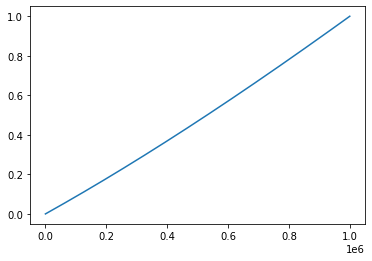

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])